# Part Combination Space Exploration

This is a notebook developed to leverage the new SysML v2 semantics for nested features and instantiation of models to generate instances of M1 system models as feedstock for analysis pipelines.

In [1]:
import requests
import getpass
import math

from __future__ import print_function

import time
import sysml_v2_api_client
from sysml_v2_api_client.rest import ApiException
from pprint import pprint

import json
import networkx as NX
import matplotlib.pyplot as plt

import random
import copy

from model_interpretation.model_loading import ModelingSession as Session

# Configure API Server Connection

In [2]:
sysml_api_base_url = 'http://sysml2-sst.intercax.com:9000'

## Activate APIs

Connect the API classes to the server

In [3]:
configuration = sysml_v2_api_client.Configuration(
    host = sysml_api_base_url
)

projects_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    project_api_instance = sysml_v2_api_client.ProjectApi(api_client)
    
commits_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    commits_api_instance = sysml_v2_api_client.CommitApi(api_client)
    
elements_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    elements_api_instance = sysml_v2_api_client.ElementApi(api_client)

## Pull down commits and elements catalogs

With the API handles, use the pre-built methods to get lists of commits and elements.

In [4]:
project_api_instance

In [5]:
kerbal_proj = [my_proj for my_proj in project_api_instance.get_projects() if my_proj.name.find('Kerbal') > -1][0]
kerbal_proj

{'id': '03e3cdfe-8d90-4fc3-a414-9a188203d349',
 'name': 'Kerbal Sat Mar 13 14:07:34 UTC 2021',
 'type': 'Project'}

In [6]:
try:
    # Get commits by project
    commits_response = commits_api_instance.get_commits_by_project(kerbal_proj.id)
    pprint(commits_response)
except ApiException as e:
    print("Exception when calling CommitApi->get_commits_by_project: %s\n" % e)

[{'change': None,
 'containing_project': {'id': '03e3cdfe-8d90-4fc3-a414-9a188203d349'},
 'id': 'e8d87282-87a8-4b3e-8d42-2ecc73aa5b74',
 'previous_commit': None,
 'type': 'Commit'}]


In [7]:
elements = []

try:
    # Get commits by project
    elements = elements_api_instance.get_elements_by_project_commit(kerbal_proj.id, commits_response[0].id)
except ApiException as e:
    print("Exception when calling ElementApi->get_elements_by_project_commit: %s\n" % e)

In [8]:
len(elements)

100

In [9]:
pprint(elements[0])

{'id': '000f78ae-e890-4f81-847c-f9bf976abe1b',
 'identifier': '000f78ae-e890-4f81-847c-f9bf976abe1b',
 'type': 'PartUsage'}


# Gather Element Data

Since the generated API doesn't have much detail for elements, need to do this more hands-on.

Not elegant below to just have a larger page size, should implement paging later on.

In [10]:
elements_url = (sysml_api_base_url +
                '/projects/{0}/commits/{1}/elements?page[size]=2000').format(kerbal_proj.id, commits_response[0].id)

In [11]:
elements_url

'http://sysml2-sst.intercax.com:9000/projects/03e3cdfe-8d90-4fc3-a414-9a188203d349/commits/e8d87282-87a8-4b3e-8d42-2ecc73aa5b74/elements?page[size]=2000'

In [12]:
elements_response = requests.get(
    elements_url
)

In [13]:
elements_data = elements_response.json()

Split the elements into relationships and non-relationships. This will let us work with graph representations and a graph understanding of the underlying model.

In [14]:
len(elements_data)

506

In [15]:
non_relations = [non_relation for non_relation in elements_data if not 'relatedElement' in non_relation]

In [16]:
relations = [relation for relation in elements_data if 'relatedElement' in relation]

In [17]:
len(non_relations)

212

In [18]:
len(relations)

294

Survey which and how many metatypes are in the model.

In [19]:
metatypes = []
for nr in elements_data:
    if nr['@type'] not in metatypes:
        metatypes.append(nr['@type'])
        
metatypes

['PartUsage',
 'Redefinition',
 'EndFeatureMembership',
 'FeatureMembership',
 'LiteralInteger',
 'AttributeUsage',
 'Subsetting',
 'Membership',
 'FeatureValue',
 'Superclassing',
 'ReturnParameterMembership',
 'LiteralReal',
 'Succession',
 'ActionUsage',
 'Feature',
 'FeatureReferenceExpression',
 'PartDefinition',
 'MultiplicityRange',
 'ResultExpressionMembership',
 'SourceEnd',
 'FeatureTyping',
 'TransitionFeatureMembership',
 'ReferenceUsage',
 'Expression',
 'ItemDefinition',
 'Import',
 'ParameterMembership',
 'TargetEnd',
 'AcceptActionUsage',
 'Package',
 'TransitionUsage',
 'OperatorExpression',
 'StateUsage',
 'InvocationExpression',
 'StateDefinition',
 'ActionDefinition',
 'Function']

Create a working session for the model and feed it the serialized data. The working session will also generate useful graphs to inspect later in this workbook.

In [20]:
working_model = Session()
working_model.thaw_json_data(elements_data)

## Show Computed Graphs

### Superclassing Graph

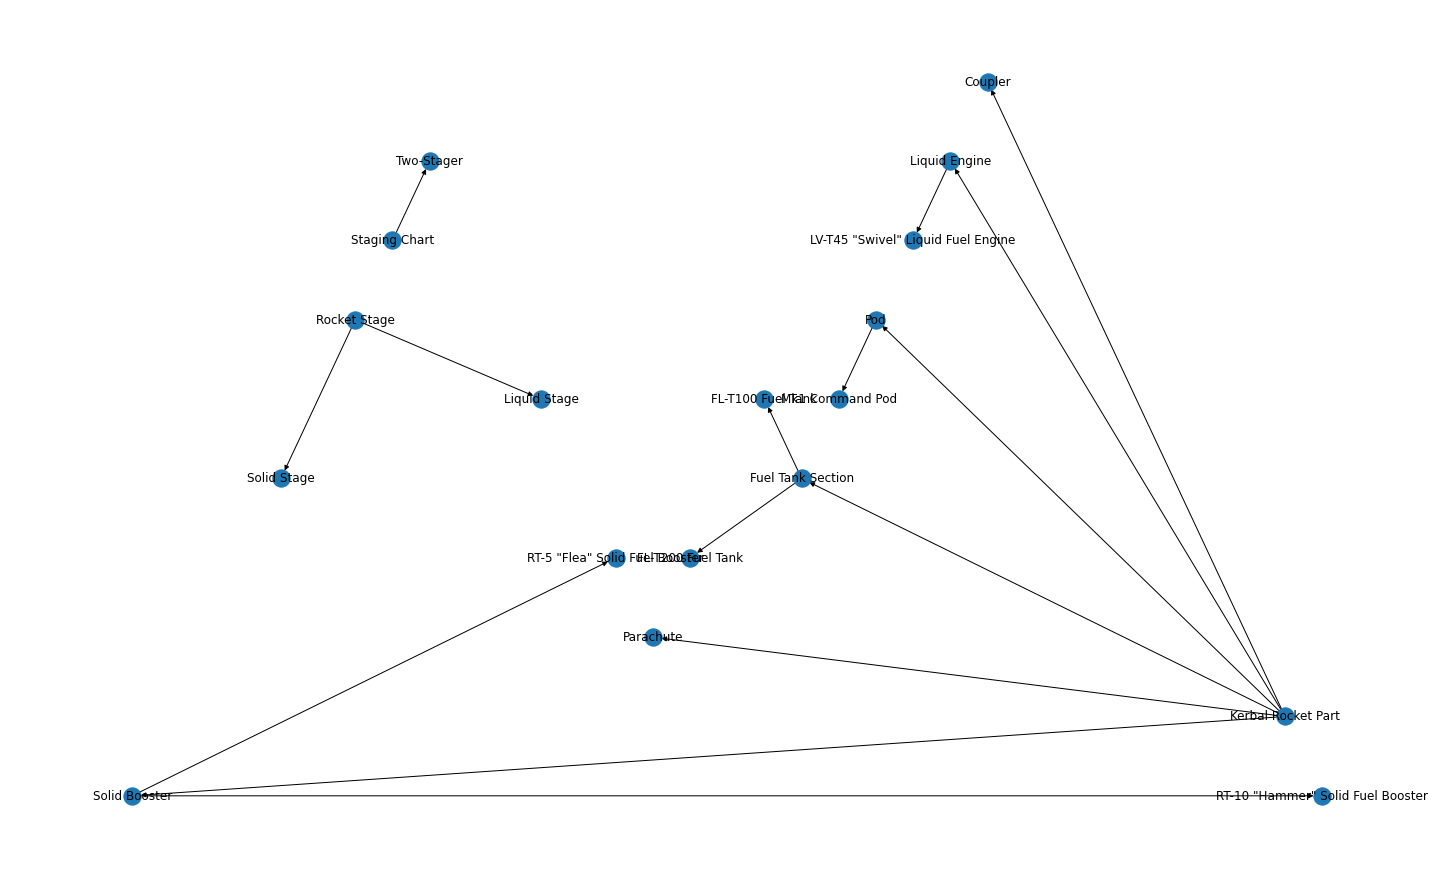

In [21]:
super_labels = NX.get_node_attributes(working_model.graph_manager.superclassing_graph,'name')

plt.figure(figsize=(20, 12))

NX.draw_planar(working_model.graph_manager.superclassing_graph,
               labels=super_labels)

### Banded Attribute Graph

In [22]:
list(working_model.graph_manager.banded_featuring_graph.successors('f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1'))

['b1e046e2-dca5-45ef-97c4-a54e15f87aea',
 '23e6504c-f6c6-4801-b5d2-60fdf2ae40a2']

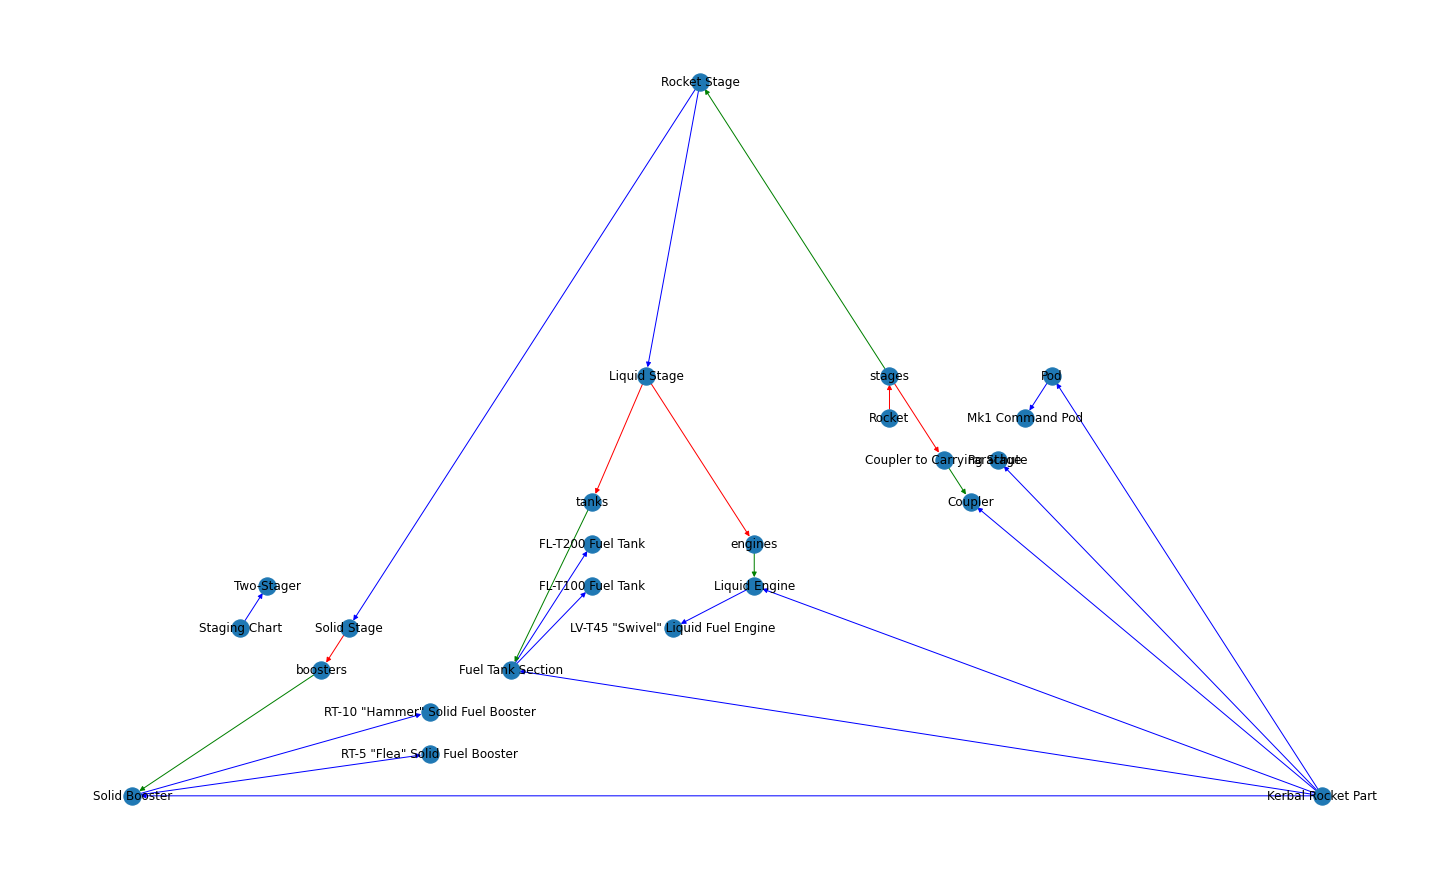

In [23]:
banded_labels = NX.get_node_attributes(working_model.graph_manager.banded_featuring_graph,'name')

edge_kinds = NX.get_edge_attributes(working_model.graph_manager.banded_featuring_graph,'kind')
colors = {}

for key, value in edge_kinds.items():
    if value == 'Superclassing':
        colors.update({key: 'b'})
    elif value == 'FeatureTyping':
        colors.update({key: 'g'})
    elif value == 'FeatureMembership':
        colors.update({key: 'r'})

plt.figure(figsize=(20, 12))

NX.draw_planar(working_model.graph_manager.banded_featuring_graph,
               labels=banded_labels,
              edge_color=colors.values())

## Inspect Part Usages

In [24]:
part_uses = working_model.get_all_of_metaclass(metaclass_name='PartUsage')

In [25]:
len(part_uses)

5

In [26]:
['{0} has multiplicity {1}..{2}'.format(
    part_use['name'],
    working_model.feature_lower_multiplicity(part_use['@id']),
    working_model.feature_upper_multiplicity(part_use['@id'])
) for part_use in part_uses]

['tanks has multiplicity 0..30',
 'boosters has multiplicity 0..8',
 'Coupler to Carrying Stage has multiplicity 0..8',
 'engines has multiplicity 0..8',
 'stages has multiplicity 1..5']

Get feature types.

In [27]:
feature_types = [feature_type for feature_type in relations if feature_type['@type'] == 'FeatureTyping']

# Refactor still in progress below this line

# Generate Instances

With the base semantic model in hand, begin to apply the rules to generate our system alternatives.

## Find number of instances for feature last positions

In SysML, the default type is PartDefinition, which is a Classifier, meaning the minimal interpretation of length one (the specific instance). Nesting parts then have an interpretation as expected by systems engineers, namely that the instances "stack" in order to provide a navigation from top-level assembly to leaf component.

In [28]:
['{0} needs {1} instances of type {2}'.format(
    part_use['name'],
    working_model.feature_upper_multiplicity(part_use['@id']),
    working_model.graph_manager.get_feature_type_name(part_use['@id'])
) for part_use in part_uses]

['tanks needs 30 instances of type Fuel Tank Section',
 'boosters needs 8 instances of type Solid Booster',
 'Coupler to Carrying Stage needs 8 instances of type Coupler',
 'engines needs 8 instances of type Liquid Engine',
 'stages needs 5 instances of type Rocket Stage']

Automatically shorten names so that sequences remain readable when printed.

In [54]:
shorten_pre_bake = {
    'RT-10 "Hammer" Solid Fuel Booster': "RT-10",
    'RT-5 "Flea" Solid Fuel Booster': "RT-5",
    'LV-T45 "Swivel" Liquid Fuel Engine': "LV-T45",
    'FL-T100 Fuel Tank': "FL-T100",
    'FL-T200 Fuel Tank': "FL-T200"
}

In [55]:
def shorten_name(name, shorten_pre_bake=None):
    short_name = ''
    if len(name) > 5:
        if shorten_pre_bake is not None:
            if name in shorten_pre_bake:
                return shorten_pre_bake[name]
        space_place = name.find(' ')
        if space_place > -1:
            short_name = short_name + name[0]
            short_name = short_name + name[space_place + 1]
            next_space = name.find(' ', space_place + 1)
            while next_space > -1:
                short_name = short_name + name[next_space + 1]
                next_space = name.find(' ', next_space + 1)
            return short_name
    return name

In [56]:
class Instance():
    def __init__(self, name, index):
        self.name = shorten_name(name) + '#' + str(index)
        
    def __repr__(self):
        return self.name

In [57]:
multiplicity_dict = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in multiplicity_dict:
        old_val = multiplicity_dict[part_use]
        multiplicity_dict.update({type_name: old_val + feature_upper_multiplicity(part_use)})
    else:
        multiplicity_dict.update({type_name: feature_upper_multiplicity(part_use)})

In [58]:
multiplicity_dict

{'Fuel Tank Section': 30,
 'Solid Booster': 8,
 'Coupler': 8,
 'Liquid Engine': 8,
 'Rocket Stage': 5}

## Determine the size of the universe of instances needed for creating alternatives

Use feature membership together with multiplicity to decide how many individuals are needed.

In [27]:
part_leaves = [model_loading.lookup.id_memo_dict[node]
    for node in working_model.graph_manager.part_featuring_graph.nodes
        if working_model.graph_manager.part_featuring_graph.in_degree(node) == 0]

NameError: name 'model_loading' is not defined

In [28]:
part_roots = [model_loading.lookup.id_memo_dict[node]
    for node in working_model.graph_manager.part_featuring_graph.nodes
        if working_model.graph_manager.part_featuring_graph.out_degree(node) == 0]

NameError: name 'model_loading' is not defined

In [64]:
banded_roots = [model_loading.lookup.id_memo_dict[node]
    for node in working_model.graph_manager.banded_featuring_graph.nodes
        if working_model.graph_manager.banded_featuring_graph.out_degree(node) == 0]

In [65]:
[part_leaf['name'] for part_leaf in part_leaves]

['tanks', 'Coupler to Carrying Stage', 'engines', 'boosters']

In [66]:
[part_root['name'] for part_root in part_roots]

['Liquid Stage', 'Solid Stage', 'Rocket']

In [67]:
[banded_root['name'] for banded_root in banded_roots]

['Rocket', 'Kerbal Rocket Part']

Correct the multiplicities by considering nesting.part_uses

In [68]:
part_multiplicity = {}

for part_use in part_uses:
    corrected_mult = 0
    for part_tree_root in banded_roots:
        try:
            part_path = NX.shortest_path(banded_feature_graph, part_use['@id'], part_tree_root['@id'])
            # TODO: check that the path actually exists
            corrected_mult = math.prod([feature_upper_multiplicity(id_memo_dict[node]) for node in part_path])
        except NX.NetworkXNoPath:
            pass
    part_multiplicity.update({part_use['@id']: corrected_mult})

In [69]:
part_multiplicity

{'000f78ae-e890-4f81-847c-f9bf976abe1b': 150,
 '5caca345-39a8-4125-9387-3a4026b59700': 40,
 'b1e046e2-dca5-45ef-97c4-a54e15f87aea': 40,
 'cd081fb5-d4b7-42bc-880b-9f4cf2517394': 40,
 'f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1': 5}

### Subdivide Abstract Feature Types

Look at the feature types for where they are abstract and then generate instances from the more specific types.

In [70]:
[get_name_by_id(node) for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

['RT-10 "Hammer" Solid Fuel Booster',
 'FL-T200 Fuel Tank',
 'FL-T100 Fuel Tank',
 'Parachute',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'Liquid Stage',
 'Solid Stage',
 'Coupler',
 'Mk1 Command Pod',
 'RT-5 "Flea" Solid Fuel Booster']

In [71]:
corrected_multiplicity_dict = {}
type_id_pairs = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in corrected_multiplicity_dict:
        old_val = corrected_multiplicity_dict[part_use]
        corrected_multiplicity_dict.update({type_name: old_val + part_multiplicity[part_use['@id']]})
    else:
        corrected_multiplicity_dict.update({type_name: part_multiplicity[part_use['@id']]})
        if len(part_use['type']) > 0:
            type_id_pairs.update({type_name: part_use['type'][0]['@id']})

In [72]:
type_id_pairs

{'Fuel Tank Section': 'c90361d5-e456-4d96-aecf-b1130825f4fd',
 'Solid Booster': '6c32c754-64ff-46e9-b654-a8af287dd3dc',
 'Coupler': 'db9b21bf-1157-4fa2-88b9-4389884fcd89',
 'Liquid Engine': '108e4293-9941-46b5-855c-06acb74ac4fc',
 'Rocket Stage': '23e6504c-f6c6-4801-b5d2-60fdf2ae40a2'}

In [73]:
corrected_multiplicity_dict

{'Fuel Tank Section': 150,
 'Solid Booster': 40,
 'Coupler': 40,
 'Liquid Engine': 40,
 'Rocket Stage': 5}

## Generate Random Alternatives

Start creating the alternatives with random draws on multiplicity. This will be our space for investigation for weights, thrust-to-weight ratios at stage ignitions, delta-Vs, and initial and burnout masses.

In [74]:
no_alts_to_create = 50

In [75]:
partitioned_multiplicity_dicts = []

for step in range(0, no_alts_to_create):

    partitioned_multiplicity_dict = {}

    for key in corrected_multiplicity_dict:
        if key in type_id_pairs:
            key_id = type_id_pairs[key]
            type_obj = id_memo_dict[key_id]
            if type_obj['isAbstract']:
                local_partition = {}
                if key_id in subclassing_graph.nodes:
                    no_splits = len(list(subclassing_graph.successors(key_id)))
                    taken = 0
                    for indx, succ in enumerate(subclassing_graph.successors(key_id)):
                        if indx < no_splits - 1:
                            draw = random.randint(0, corrected_multiplicity_dict[key])
                            taken = taken + draw
                        else:
                            draw = corrected_multiplicity_dict[key] - taken
                        local_partition.update({get_name_by_id(succ): draw})
                partitioned_multiplicity_dict.update({key: local_partition})
            else:
                partitioned_multiplicity_dict.update({key: corrected_multiplicity_dict[key]})
                
    partitioned_multiplicity_dicts.append(partitioned_multiplicity_dict)

In [76]:
partitioned_multiplicity_dicts[0]

{'Fuel Tank Section': {'FL-T200 Fuel Tank': 14, 'FL-T100 Fuel Tank': 136},
 'Solid Booster': {'RT-10 "Hammer" Solid Fuel Booster': 9,
  'RT-5 "Flea" Solid Fuel Booster': 31},
 'Coupler': 40,
 'Liquid Engine': {'LV-T45 "Swivel" Liquid Fuel Engine': 40},
 'Rocket Stage': {'Liquid Stage': 1, 'Solid Stage': 4}}

- [ ] TODO: Fix the dictionary to have keys as IDs, not name

In [77]:
classifier_instance_dicts = []
classifier_memo_dicts = []

for step in range(0, no_alts_to_create):

    classifier_instance_dict = {}
    classifier_memo_dict = {}
    
    partitioned_multiplicity_dict = partitioned_multiplicity_dicts[step]

    for mult_key in partitioned_multiplicity_dict:
        instances_list = []
        if isinstance(partitioned_multiplicity_dict[mult_key], dict):
            for special_key in partitioned_multiplicity_dict[mult_key]:
                sub_instances_list = []
                instances_number = (partitioned_multiplicity_dict[mult_key][special_key] + 1)
                for index in range(1, instances_number):
                    new_instance = Instance(special_key, index)
                    instances_list.append(new_instance)
                    sub_instances_list.append(new_instance)
                    classifier_memo_dict.update({new_instance.name: [special_key, mult_key]})
                classifier_instance_dict.update({special_key: sub_instances_list})
            classifier_instance_dict.update({mult_key: instances_list})
        else:
            instances_number = (corrected_multiplicity_dict[mult_key] + 1)
            for index in range(1, instances_number):
                new_instance = Instance(mult_key, index)
                instances_list.append(new_instance)
                classifier_memo_dict.update({new_instance.name: [mult_key]})
            classifier_instance_dict.update({mult_key: instances_list})
            
    classifier_instance_dicts.append(classifier_instance_dict)
    classifier_memo_dicts.append(classifier_memo_dict)

In [78]:
list(classifier_instance_dicts[0].keys())

['FL-T200 Fuel Tank',
 'FL-T100 Fuel Tank',
 'Fuel Tank Section',
 'RT-10 "Hammer" Solid Fuel Booster',
 'RT-5 "Flea" Solid Fuel Booster',
 'Solid Booster',
 'Coupler',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'Liquid Engine',
 'Liquid Stage',
 'Solid Stage',
 'Rocket Stage']

Now that the universe of instances has been calculated, we can look at how they can be sequenced. This method is probably fragile so will need revisions.

In [78]:
[get_name_by_id(node) for node in NX.topological_sort(part_featuring_graph.reverse())]

['Rocket',
 'stages',
 'Coupler to Carrying Stage',
 'Solid Stage',
 'boosters',
 'Liquid Stage',
 'engines',
 'tanks']

In [79]:
sorted_feature_groups = []

In [80]:
for comp in NX.connected_components(part_featuring_graph.to_undirected()):
    connected_sub = NX.subgraph(part_featuring_graph, list(comp))
    sorted_feature_groups.append(
        [node for node in NX.topological_sort(connected_sub.reverse())]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub.reverse())])

['Liquid Stage', 'engines', 'tanks']
['Rocket', 'stages', 'Coupler to Carrying Stage']
['Solid Stage', 'boosters']


In [81]:
sorted_feature_groups

[['f25193df-abf0-478b-997d-dbee3895090e',
  'cd081fb5-d4b7-42bc-880b-9f4cf2517394',
  '000f78ae-e890-4f81-847c-f9bf976abe1b'],
 ['64811484-97f6-442e-ab02-cd5247255cab',
  'f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1',
  'b1e046e2-dca5-45ef-97c4-a54e15f87aea'],
 ['0b2ea820-ba6b-4f8a-a898-8694dc0a247d',
  '5caca345-39a8-4125-9387-3a4026b59700']]

In [82]:
for classifier_instance_dict in classifier_instance_dicts:

    for part_tree_root in part_roots:
        root_name = get_name_by_id(part_tree_root['@id'])
        if root_name not in classifier_instance_dict:
            classifier_instance_dict.update({root_name: Instance(root_name, 1)})

The topological sort on the graph of feature membership determines the order in which to build up sets of instances for features.

In [83]:
feature_sequence_dictionaries = []

for step in range(0, no_alts_to_create):
    
    classifier_instance_dict = classifier_instance_dicts[step]
    
    feature_sequence_dictionary = {}
    covered_draw_dict = {}
    
    for sorting in sorted_feature_groups:
        for indx, node in enumerate(sorting):
            if indx > 0:
                new_dict = {}
                # get current parent from the graph
                for pred in part_featuring_graph.successors(node):
                    current_parent = pred
                    #print(get_name_by_id(current_parent))

                sequence_of_sequences = []

                for sequence in feature_sequence_dictionary[current_parent]:

                    test_mult = random.randint(
                        feature_lower_multiplicity(id_memo_dict[node]),
                        feature_upper_multiplicity(id_memo_dict[node])
                    )

                    for ind_j in range(0, test_mult):
                        new_sequence = copy.deepcopy(sequence)
                        # find the type of the current feature node
                        node_type = get_feature_type_name(id_memo_dict[node])

                        need_draw = True
                        
                        safety_count = 0

                        while(need_draw and safety_count < 100):

                            draw = random.randint(
                                0,
                                corrected_multiplicity_dict[node_type] - 1
                            )
                            #print(classifier_instance_dict[node_type][draw])

                            if node_type in covered_draw_dict:
                                if classifier_instance_dict[node_type][draw] in covered_draw_dict[node_type]:
                                    pass
                                    #need_draw = False
                                else:
                                    covered_draw_dict[node_type].append(classifier_instance_dict[node_type][draw])
                                    need_draw = False
                            else:
                                covered_draw_dict.update({node_type : [classifier_instance_dict[node_type][draw]]})
                                need_draw = False

                            safety_count = safety_count + 1
                            if safety_count == 99:
                                print('Safety count hit when trying to place ' + 
                                      str(classifier_instance_dict[node_type][draw]) + ' under ' +
                                     str(new_sequence))
                                print('Covered dict is ' + str(covered_draw_dict[node_type]))
                        
                        new_sequence.append(classifier_instance_dict[node_type][draw])

                        sequence_of_sequences.append(new_sequence)

                feature_sequence_dictionary.update({node: sequence_of_sequences})

            elif indx == 0:
                if isinstance(classifier_instance_dict[get_name_by_id(node)], list):
                    starter_list = []
                    for item in classifier_instance_dict[get_name_by_id(node)]:
                        starter_list.append([item])
                    # handle case where main type has more than one instance
                    feature_sequence_dictionary.update({node: starter_list})
                    #print(starter_list)
                    if len(starter_list) == 0:
                        break
                else:
                    feature_sequence_dictionary.update({node: [[classifier_instance_dict[get_name_by_id(node)]]]})
            
    feature_sequence_dictionaries.append(feature_sequence_dictionary)

In [84]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in feature_sequence_dictionary:
            print(get_name_by_id(key) + ', id ' + key)
            for seq in feature_sequence_dictionary[key]:
                print(str(seq))

Solution #0
Liquid Stage, id f25193df-abf0-478b-997d-dbee3895090e
[LS#1]
[LS#2]
[LS#3]
engines, id cd081fb5-d4b7-42bc-880b-9f4cf2517394
[LS#1, LV-T45#2]
[LS#1, LV-T45#26]
[LS#2, LV-T45#28]
[LS#2, LV-T45#8]
[LS#2, LV-T45#19]
[LS#3, LV-T45#22]
[LS#3, LV-T45#5]
tanks, id 000f78ae-e890-4f81-847c-f9bf976abe1b
[LS#1, FL-T200#18]
[LS#1, FL-T200#25]
[LS#1, FL-T200#24]
[LS#1, FL-T200#2]
[LS#1, FL-T200#9]
[LS#1, FL-T200#76]
[LS#1, FL-T100#56]
[LS#1, FL-T200#40]
[LS#1, FL-T200#32]
[LS#1, FL-T200#93]
[LS#1, FL-T200#52]
[LS#1, FL-T200#19]
[LS#1, FL-T200#59]
[LS#1, FL-T200#74]
[LS#1, FL-T200#53]
[LS#1, FL-T100#57]
[LS#1, FL-T200#6]
[LS#1, FL-T200#15]
[LS#1, FL-T100#45]
[LS#1, FL-T200#73]
[LS#1, FL-T100#36]
[LS#1, FL-T100#44]
[LS#1, FL-T200#81]
[LS#1, FL-T100#27]
[LS#1, FL-T100#4]
[LS#1, FL-T200#57]
[LS#1, FL-T200#30]
[LS#2, FL-T200#84]
[LS#2, FL-T200#12]
[LS#2, FL-T100#26]
[LS#2, FL-T100#28]
[LS#2, FL-T200#26]
[LS#2, FL-T200#75]
[LS#2, FL-T100#46]
[LS#2, FL-T100#21]
[LS#2, FL-T200#60]
[LS#2, FL-T100

One more step here is to backfill the more general collections of type with what has been developed above. To make it easier to visualize, repeat the superclassing graph from before. The only thing to add is the base library kinds.

In [85]:
class_roots = [node for node in superclassing_graph.nodes if superclassing_graph.out_degree(node) == 0]
class_roots

['2aa4c385-1247-4f22-b141-4e73a054dc7b',
 '23e6504c-f6c6-4801-b5d2-60fdf2ae40a2']

We want to look at the classifier_instance_dicts in order to see if there are classifiers without entries. If we find missing keys, look to their subsets to fill in.

In [86]:
sorted_class_groups = []

for comp in NX.connected_components(superclassing_graph.to_undirected()):
    component_list = []
    connected_sub = NX.subgraph(superclassing_graph, list(comp))
    sorted_class_groups.append(
        [node for node in NX.topological_sort(connected_sub)]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub)])

['RT-5 "Flea" Solid Fuel Booster', 'Mk1 Command Pod', 'Pod', 'Coupler', 'LV-T45 "Swivel" Liquid Fuel Engine', 'Liquid Engine', 'Parachute', 'FL-T100 Fuel Tank', 'FL-T200 Fuel Tank', 'Fuel Tank Section', 'RT-10 "Hammer" Solid Fuel Booster', 'Solid Booster', 'Kerbal Rocket Part']
['Solid Stage', 'Liquid Stage', 'Rocket Stage']


In [87]:
founds = []
for sorted_group in sorted_class_groups:
    for sorted_thing in sorted_group:
        if get_name_by_id(sorted_thing) in classifier_instance_dicts[0]:
            founds.append(sorted_thing)

In [88]:
for classifier_instance_dict in classifier_instance_dicts:
    for found in founds:
        my_group = []
        for sorted_group in sorted_class_groups:
            for thing in sorted_group:
                if thing == found:
                    my_group = sorted_group
                    break
        for item in my_group:
            if not item in founds:
                try:
                    super_path = NX.shortest_path(superclassing_graph, found, item)
                    #print ('Found path from ' + get_name_by_id(found) + ' to ' + get_name_by_id(item))
                    if get_name_by_id(item) not in classifier_instance_dict:
                        classifier_instance_dict.update({get_name_by_id(item): 
                                                        copy.deepcopy(classifier_instance_dict[get_name_by_id(found)])})
                    else:
                        for individual in classifier_instance_dict[get_name_by_id(found)]:
                            if individual not in classifier_instance_dict[get_name_by_id(item)]:
                                classifier_instance_dict[get_name_by_id(item)].append(individual)
                            #classifier_instance_dict[get_name_by_id(item)].extend(classifier_instance_dict[get_name_by_id(found)])
                except NX.NetworkXNoPath:
                    pass

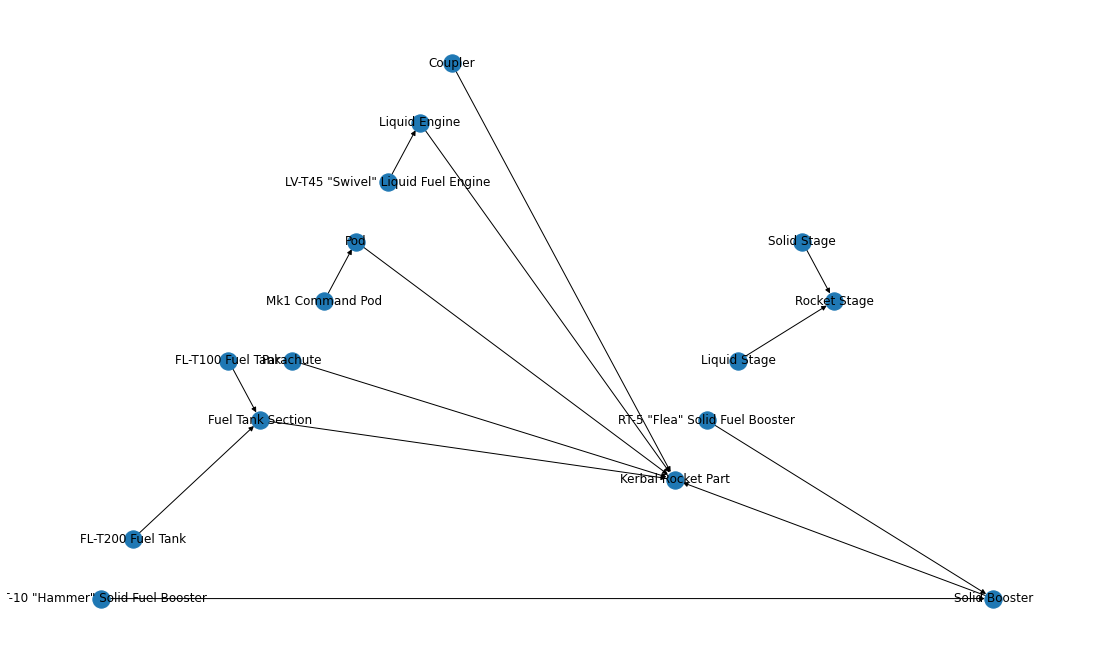

In [80]:
plt.figure(figsize=(15, 9))
NX.draw_planar(superclassing_graph, labels=superclassing_graph_labels)

# Analyze and Explore Resulting Space

Now that the alternatives have been generated, we can explore the population

In [90]:
[[get_name_by_id(node), node] for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

[['RT-10 "Hammer" Solid Fuel Booster', '276d0623-a352-49cd-8faa-132792ec156a'],
 ['FL-T200 Fuel Tank', 'c2501561-e875-4c47-8e88-65ddd846d20b'],
 ['FL-T100 Fuel Tank', '5260380b-6fda-43cc-993f-5df58868edbb'],
 ['Parachute', '156f9c43-0fbe-425b-89b4-db1aeeafb7c5'],
 ['LV-T45 "Swivel" Liquid Fuel Engine',
  '7e8c5105-bdd1-4cde-9133-c17ab1183f6a'],
 ['Liquid Stage', 'f25193df-abf0-478b-997d-dbee3895090e'],
 ['Solid Stage', '0b2ea820-ba6b-4f8a-a898-8694dc0a247d'],
 ['Coupler', 'db9b21bf-1157-4fa2-88b9-4389884fcd89'],
 ['Mk1 Command Pod', '7680d01c-e978-4ecb-8349-f2336bc6aaac'],
 ['RT-5 "Flea" Solid Fuel Booster', 'c29c33af-197a-426a-b2a3-b222d2f21307']]

## Gather AttributeUsages and literal values

Find all the attribute usages so we can navigate to them from our parts library.

TODO: Look at using FeatureValue relationships for this

In [91]:
def get_att_literal_values(att_use):
    literal_values = []
    for att_member in att_use['ownedMember']:
        if att_member['@id'] in id_memo_dict:
            if id_memo_dict[att_member['@id']]['@type'] == 'LiteralReal':
                literal_values.append(id_memo_dict[att_member['@id']])
                
    return literal_values

In [92]:
att_uses = [att_use for att_use in non_relations if att_use['@type'] == 'AttributeUsage']
for att_use in att_uses:
    id_memo_dict.update({att_use['@id']: att_use})

Get literal reals to connect to attributes.

In [93]:
reals = [real for real in non_relations if real['@type'] == 'LiteralReal']
for real in reals:
    id_memo_dict.update({real['@id']: real})

Create objects to hold different values per instance.

In [94]:
class ValueHolder():
    
    def __init__(self, path, name, value, base_att):
        # path is list of instance references
        self.holder_string = ''
        for indx, step in enumerate(path):
            if indx == 0:
                self.holder_string = str(step)
            else:
                self.holder_string = self.holder_string + '.' + str(step)
        self.holder_string = self.holder_string + '.' + name
        self.value = value
        self.base_att = base_att
    
    def __repr__(self):
        if self.value is not None:
            return self.holder_string + ' (' + str(self.value) + ')'
        else:
            return self.holder_string + ' (unset)'

Get expressions attached to attributes as values.

In [95]:
found_ele = [found for found in non_relations if found['@id'] == 'ced4f691-07ff-45dd-a2cd-687bc3bb8942']

In [96]:
type_values = {}

for att_use in att_uses:
    if len(att_use['ownedMember']) > 0:
        typ = id_memo_dict[att_use['owningType']['@id']]
        for att_member in att_use['ownedMember']:
            for value in get_att_literal_values(att_use):
                print (att_use['name'] + ' of ' + typ['name'] + ' = ' + str(value['value']))
                if att_use['name'] in type_values:
                    type_values[att_use['name']].update({typ['name']: value['value']})
                else:
                    type_values.update({att_use['name']: {typ['name']: value['value']}})

Full Mass of FL-T100 Fuel Tank = 0.5625
Specific Impulse of LV-T45 "Swivel" Liquid Fuel Engine = 170.0
Specific Impulse of RT-10 "Hammer" Solid Fuel Booster = 170.0
Empty Mass of RT-10 "Hammer" Solid Fuel Booster = 0.75
Specific Impulse of RT-5 "Flea" Solid Fuel Booster = 140.0
Empty Mass of FL-T200 Fuel Tank = 0.125
Full Mass of FL-T200 Fuel Tank = 1.125
Full Mass of RT-5 "Flea" Solid Fuel Booster = 1.5
Thrust of RT-5 "Flea" Solid Fuel Booster = 162.91
Empty Mass of RT-5 "Flea" Solid Fuel Booster = 0.45
Thrust of LV-T45 "Swivel" Liquid Fuel Engine = 167.97
Full Mass of RT-10 "Hammer" Solid Fuel Booster = 3.56
Empty Mass of FL-T100 Fuel Tank = 0.0625
Thrust of RT-10 "Hammer" Solid Fuel Booster = 197.9
Mass of LV-T45 "Swivel" Liquid Fuel Engine = 1.5


In [97]:
type_values

{'Full Mass': {'FL-T100 Fuel Tank': 0.5625,
  'FL-T200 Fuel Tank': 1.125,
  'RT-5 "Flea" Solid Fuel Booster': 1.5,
  'RT-10 "Hammer" Solid Fuel Booster': 3.56},
 'Specific Impulse': {'LV-T45 "Swivel" Liquid Fuel Engine': 170.0,
  'RT-10 "Hammer" Solid Fuel Booster': 170.0,
  'RT-5 "Flea" Solid Fuel Booster': 140.0},
 'Empty Mass': {'RT-10 "Hammer" Solid Fuel Booster': 0.75,
  'FL-T200 Fuel Tank': 0.125,
  'RT-5 "Flea" Solid Fuel Booster': 0.45,
  'FL-T100 Fuel Tank': 0.0625},
 'Thrust': {'RT-5 "Flea" Solid Fuel Booster': 162.91,
  'LV-T45 "Swivel" Liquid Fuel Engine': 167.97,
  'RT-10 "Hammer" Solid Fuel Booster': 197.9},
 'Mass': {'LV-T45 "Swivel" Liquid Fuel Engine': 1.5}}

- [ ] TODO: Factor the above as sequences of instances rather than going back to the type

## Create Attribute Sequences

Add attributes to the sequences for parts, and where there are values, add those to the sequence also.

Get the attribute use redefinition graph to see where the usage sets may have to be set equal to each other. A more general attribute that is redefined by a more specific one must have the same list of values as the specific one.

In [98]:
redefinitons = [redef for redef in relations if redef['@type'] == 'Redefinition']

In [99]:
attribute_redefinition_graph = NX.DiGraph()

for redef in redefinitons:
    try:
        redef_name = get_data_by_id(redef['redefinedFeature']['@id'])['owningType']['@id']
        redefining_name = get_data_by_id(redef['redefiningFeature']['@id'])['owningType']['@id']
        attribute_redefinition_graph.add_edge(redef['redefiningFeature']['@id'],redef['redefinedFeature']['@id'])
    except TypeError:
        pass

In [100]:
redef_orders = []

for comp in NX.connected_components(attribute_redefinition_graph.to_undirected()):
    connected_sub = NX.subgraph(attribute_redefinition_graph, list(comp))
    sorted_feature_groups.append(
        [node for node in NX.topological_sort(connected_sub)]
    )
    look_upward = []
    redef_list = []
    for node in NX.topological_sort(connected_sub):
        owner_name = get_data_by_id(get_data_by_id(node)['owningType']['@id'])['name']
        redef_list.append(node)
        look_upward.append(owner_name + '::' + get_name_by_id(node))
    print(look_upward)
    redef_orders.append(redef_list)

['RT-5 "Flea" Solid Fuel Booster::Thrust', 'RT-10 "Hammer" Solid Fuel Booster::Thrust', 'Solid Booster::Thrust']
['FL-T100 Fuel Tank::Full Mass', 'FL-T200 Fuel Tank::Full Mass', 'Fuel Tank Section::Full Mass']
['FL-T100 Fuel Tank::Empty Mass', 'FL-T200 Fuel Tank::Empty Mass', 'Fuel Tank Section::Empty Mass']
['RT-5 "Flea" Solid Fuel Booster::Specific Impulse', 'RT-10 "Hammer" Solid Fuel Booster::Specific Impulse', 'Solid Booster::Specific Impulse']
['RT-5 "Flea" Solid Fuel Booster::Empty Mass', 'RT-10 "Hammer" Solid Fuel Booster::Empty Mass', 'Solid Booster::Empty Mass']
['LV-T45 "Swivel" Liquid Fuel Engine::Thrust', 'Liquid Engine::Thrust']
['LV-T45 "Swivel" Liquid Fuel Engine::Mass', 'Kerbal Rocket Part::Mass']
['LV-T45 "Swivel" Liquid Fuel Engine::Specific Impulse', 'Liquid Engine::Specific Impulse']
['RT-10 "Hammer" Solid Fuel Booster::Full Mass', 'RT-5 "Flea" Solid Fuel Booster::Full Mass', 'Solid Booster::Full Mass']


Get the attribute to value graph in order to track which attributes have values.

In [101]:
attribute_member_value_graph = NX.DiGraph()

for att in att_uses:
    if att['@id'] in id_memo_dict:
        if id_memo_dict[att['@id']]['@type'] == 'AttributeUsage':
            attribute_member_value_graph.add_edge(att['@id'], att['owningType']['@id'])
            for value in get_att_literal_values(att):
                attribute_member_value_graph.add_edge(value['@id'], att['@id'])

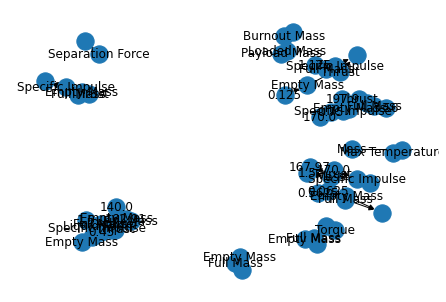

In [102]:
attribute_member_value_graph_labels = {}
for node in attribute_member_value_graph.nodes():
    if id_memo_dict[node]['@type'] == 'AttributeUsage':
        attribute_member_value_graph_labels.update({node: get_name_by_id(node)})
    elif id_memo_dict[node]['@type'] == 'LiteralReal':
        attribute_member_value_graph_labels.update({node: id_memo_dict[node]['value']})
    
NX.draw_spring(attribute_member_value_graph, labels=attribute_member_value_graph_labels)

### Match Attributes to Classifier types

Where the owningType of the Attribute usage is a classifier, use it as the base of the sequence.

In [103]:
classifier_instance_dicts[0].keys()

dict_keys(['FL-T200 Fuel Tank', 'FL-T100 Fuel Tank', 'Fuel Tank Section', 'RT-10 "Hammer" Solid Fuel Booster', 'RT-5 "Flea" Solid Fuel Booster', 'Solid Booster', 'Coupler', 'LV-T45 "Swivel" Liquid Fuel Engine', 'Liquid Engine', 'Liquid Stage', 'Solid Stage', 'Rocket Stage', 'Rocket', 'Kerbal Rocket Part'])

Need to order att_uses in the following order:
- Neither redefined or redefining
- Least to most redefined

In [104]:
plain_atts = []

for att in att_uses:
    att_found = False
    for redef in redefinitons:
        if att['@id'] == redef['redefinedFeature']['@id'] or att['@id'] == redef['redefiningFeature']['@id']:
            att_found = True
            break
    if not att_found:
        print(get_name_by_id(att['owningType']['@id']) + '::' + att['name'])
        plain_atts.append(att['@id'])

Kerbal Rocket Part::Max Temperature
Liquid Stage::Full Mass
stages::Burnout Mass
Liquid Stage::Empty Mass
stages::Loaded Mass
Fuel Tank Section::Oxidizer
Fuel Tank Section::Liquid Fuel
Coupler to Carrying Stage::Separation Force
Solid Stage::Empty Mass
stages::Payload Mass
Pod::Torque
Solid Stage::Full Mass


In [105]:
plain_atts

['01341d2c-a4ce-4f35-8c11-652be9d6b58c',
 '25a4a485-735c-4b5d-8d6f-140e176a144f',
 '2a795610-4d4a-4c6f-b4eb-3e175f85455d',
 '49fa2a78-e24a-4960-820b-f383aad10175',
 '52e2f198-482d-4992-a85b-0f7127ee6162',
 '60592e22-8668-48bd-a5b5-811b575af08d',
 '8f9ba41c-c557-42ab-a81d-4838e62db52c',
 'b305f6ce-2acb-4852-8a8a-1cfb22b2439a',
 'b83d0dc4-a7dc-4ef4-8b72-db39d34b09ee',
 'dbff731a-593e-442c-99f0-a54001dea138',
 'dc8b3968-f2e3-4806-90f7-7651bf9196ac',
 'e99d7f0f-4ad6-4223-8ca8-6d83c040c058']

In [106]:
redef_orders

[['86f2aed2-3801-420a-8df0-665d6b69c193',
  'de02c870-1658-4a34-bd03-832f8efa741d',
  '34294966-7022-4b19-bec9-e92da83702a9'],
 ['0b4921a6-6923-40a2-941c-ac726cc2eb07',
  '5de9ac2d-2879-4e44-978b-52307c4fd698',
  'f912dc27-fc5e-48e8-abf7-29d3f47c913c'],
 ['dd332374-c114-481e-bffd-6b99914bac4f',
  '5c13fffc-dfa1-41f4-b34d-d999b837b278',
  'cb4386fe-67d9-4743-995f-5d4a4162e26e'],
 ['40a619db-be4b-427a-b303-2c945d2004ef',
  '2ca7bab9-4bf5-4beb-9193-b66221fbf308',
  'a9c33eca-038f-4f35-8e2c-63fdfc3eff22'],
 ['b8173879-3e86-4770-81ef-592f02800554',
  '2d2f2249-1151-4717-aa3b-039652c8bf4e',
  '51ef7947-2aab-4abc-8276-f19363d7f73f'],
 ['d1ea4468-efba-48d9-aa9e-376669453e5b',
  'c6497b27-5dcb-4bae-bd92-86179a5daeab'],
 ['fe335d3c-ba21-41bf-8e4b-a52d1c9590f0',
  '6045bd07-09d9-4a01-97a4-ede5cad64d76'],
 ['10c42299-eb57-4ede-92ad-af66367a2e6e',
  '5b503408-eb47-4931-8365-891df10a96f3'],
 ['d59b76e9-7d47-42f4-9a6c-82f350158deb',
  '7b9876df-d176-4d78-a2f1-34e93572ecb1',
  '9d138c7a-9e26-4d30-90d2

In [107]:
ordered_atts = []
for att in plain_atts:
    ordered_atts.append(id_memo_dict[att])
for red_seq in redef_orders:
    for att in red_seq:
        ordered_atts.append(id_memo_dict[att])

In [108]:
att_value_dicts = []
value_holders = []

for classifier_instance_dict in classifier_instance_dicts:

    att_value_dict = {}

    for att in ordered_atts:
        new_sequences = []
        att_owning_type = id_memo_dict[att['owningType']['@id']]
        if att_owning_type['@type'] == 'PartDefinition':
            # need to check for redefintion here - if redefined, point to values from redefining
            if att['@id'] not in plain_atts:
                atts_to_grab = []
                for redef in redef_orders:
                    if att['@id'] in redef:
                        for red_att in redef:
                            if red_att != att['@id']:
                                try:
                                    collect_path = NX.shortest_path(attribute_redefinition_graph, red_att, att['@id'])
                                    atts_to_grab.append(red_att)

                                except NX.NetworkXNoPath:
                                    pass
                if len(atts_to_grab) > 0:
                    #print('Atts to grab for ' + att['@id'] + ' are ' + str(atts_to_grab))
                    for atg in atts_to_grab:
                        for new_seq in att_value_dict[atg]:
                            new_sequences.append(new_seq)
                                
            if att['@id'] in plain_atts or len(atts_to_grab) == 0:
                if att_owning_type['name'] in classifier_instance_dict:
                    for instance in classifier_instance_dict[att_owning_type['name']]:
                        new_sequence = []
                        new_sequence.append(instance)

                        #new_sequence.append(att['name'])

                        for value in get_att_literal_values(att):
                            #new_sequence.append(value['@id'])
                            new_holder = ValueHolder([instance], att['name'], value['value'], att)
                            value_holders.append(new_holder)
                            new_sequence.append(new_holder)

                        if len(get_att_literal_values(att)) == 0:
                            new_holder = ValueHolder([instance], att['name'], None, att)
                            new_sequence.append(new_holder)
                        new_sequences.append(new_sequence)

        att_value_dict.update({att['@id']: new_sequences})
        
    att_value_dicts.append(att_value_dict)

TODO: The block below still needs to become aware of redefines

In [109]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    
    att_value_dict = att_value_dicts[indx]
    
    for att in ordered_atts:
        new_sequences = []
        att_owning_type = id_memo_dict[att['owningType']['@id']]
        if att_owning_type['@type'] == 'PartUsage':
            if att['@id'] not in plain_atts:
                atts_to_grab = []
                for redef in redef_orders:
                    if att['@id'] in redef:
                        for red_att in redef:
                            if red_att != att['@id']:
                                try:
                                    collect_path = NX.shortest_path(attribute_redefinition_graph, red_att, att['@id'])
                                    atts_to_grab.append(red_att)

                                except NX.NetworkXNoPath:
                                    pass
                if len(atts_to_grab) > 0:
                    #print('Atts to grab for ' + att['@id'] + ' are ' + str(atts_to_grab))
                    for atg in atts_to_grab:
                        for new_seq in att_value_dict[atg]:
                            new_sequences.append(new_seq)
                            
            if att_owning_type['@id'] in feature_sequence_dictionary or len(atts_to_grab) == 0:
                for instance_sequence in feature_sequence_dictionary[att_owning_type['@id']]:
                    new_sequence = copy.deepcopy(instance_sequence)
                    
                    #new_sequence.append(att['name'])
                    
                    for value in get_att_literal_values(att):
                        #new_sequence.append(value['@id'])
                        new_holder = ValueHolder(instance_sequence, att['name'], value['value'], att)
                        value_holders.append(new_holder)
                        new_sequence.append(new_holder)
                        
                    if len(get_att_literal_values(att)) == 0:
                        new_holder = ValueHolder(instance_sequence, att['name'], None, att)
                        new_sequence.append(new_holder)
                    new_sequences.append(new_sequence)

            att_value_dict.update({att['@id']: new_sequences})
        
    att_value_dicts.append(att_value_dict)

In [110]:
for indx, att_value_dict in enumerate(att_value_dicts):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in att_value_dict:
            print(get_name_by_id(key) + ' under ' + \
                  str(id_memo_dict[id_memo_dict[key]['owningType']['@id']]['name']) + ', id ' + key)
            for indx, seq in enumerate(att_value_dict[key]):
                if indx < 5:
                    seq_string = []
                    for member in seq:
                        if isinstance(member, str) and member in id_memo_dict:
                            obj = id_memo_dict[member]
                            # TODO: Create unique value objects for formula mapping
                            if obj['@type'] == 'LiteralReal':
                                seq_string.append(str(obj['value']) + ', id ' + member)
                        else:
                            seq_string.append(member)
                    print(seq_string)
                elif indx == 5:
                    print('..')

Solution #0
Max Temperature under Kerbal Rocket Part, id 01341d2c-a4ce-4f35-8c11-652be9d6b58c
[RT-5#1, RT-5#1.Max Temperature (unset)]
[Coupler#1, Coupler#1.Max Temperature (unset)]
[Coupler#2, Coupler#2.Max Temperature (unset)]
[Coupler#3, Coupler#3.Max Temperature (unset)]
[Coupler#4, Coupler#4.Max Temperature (unset)]
..
Full Mass under Liquid Stage, id 25a4a485-735c-4b5d-8d6f-140e176a144f
[LS#1, LS#1.Full Mass (unset)]
[LS#2, LS#2.Full Mass (unset)]
[LS#3, LS#3.Full Mass (unset)]
Burnout Mass under stages, id 2a795610-4d4a-4c6f-b4eb-3e175f85455d
[Rocket#1, LS#3, Rocket#1.LS#3.Burnout Mass (unset)]
[Rocket#1, LS#1, Rocket#1.LS#1.Burnout Mass (unset)]
Empty Mass under Liquid Stage, id 49fa2a78-e24a-4960-820b-f383aad10175
[LS#1, LS#1.Empty Mass (unset)]
[LS#2, LS#2.Empty Mass (unset)]
[LS#3, LS#3.Empty Mass (unset)]
Loaded Mass under stages, id 52e2f198-482d-4992-a85b-0f7127ee6162
[Rocket#1, LS#3, Rocket#1.LS#3.Loaded Mass (unset)]
[Rocket#1, LS#1, Rocket#1.LS#1.Loaded Mass (unset)]
O

Now we need to do this for the feature sequences.

## Gather Expressions and Invocations and Build Expression Graph

In [111]:
expression_graph = NX.DiGraph()
expression_graph_labels = {}
expression_graph_ascii = ''

invocations = []


Memoize InvocationExpressions, BlockExpressions, FeatureReferenceExpressions, and ReferenceUsages

In [112]:
invocations = [invocation for invocation in non_relations if invocation['@type'] == 'InvocationExpression']
functions = [function for function in non_relations if function['@type'] == 'Function']
op_exprs = [function for function in non_relations if function['@type'] == 'OperatorExpression']
block_exprs = [block_expr for block_expr in non_relations if block_expr['@type'] == 'BlockExpression']
feature_refs = [feature_ref for feature_ref in non_relations if feature_ref['@type'] == 'FeatureReferenceExpression']
reference_uses = [ref_use for ref_use in non_relations if ref_use['@type'] == 'ReferenceUsage']

para_members = [para_member for para_member in relations if para_member['@type'] == 'ParameterMembership']
res_expr_members = [res_expr_member for res_expr_member in relations if res_expr_member['@type'] == 'ResultExpressionMembership']
ret_para_members = [ret_para_member for ret_para_member in relations if ret_para_member['@type'] == 'ReturnParameterMembership']

for invocation in invocations:
    id_memo_dict.update({invocation['@id']: invocation})
    
for function in functions:
    id_memo_dict.update({function['@id']: function})
    
for op_expr in op_exprs:
    id_memo_dict.update({op_expr['@id']: op_expr})
    
for block_expr in block_exprs:
    id_memo_dict.update({block_expr['@id']: block_expr})
    
for feature_ref in feature_refs:
    id_memo_dict.update({feature_ref['@id']: feature_ref})
    
for reference_use in reference_uses:
    id_memo_dict.update({reference_use['@id']: reference_use})

In [113]:
ofms = []
ofms.extend(para_members)
ofms.extend(res_expr_members)
ofms.extend(ret_para_members)

Get feature memberships from the expressions to their members.

In [114]:
for fm in feature_members:
    if fm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'InvocationExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['name']})
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'OperatorExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['operator']})
            if fm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[fm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({fm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[fm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})

for ofm in ofms:
    if ofm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[ofm['owningType']['@id']]['@type'] == 'BlockExpression':
            expression_graph.add_edge(ofm['owningType']['@id'], ofm['memberFeature']['@id'])
            if ofm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[ofm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})
            if get_name_by_id(ofm['memberFeature']['@id']) is not None:
                if get_metatype_by_id(ofm['memberFeature']['@id']) == 'ReferenceUsage':
                    ref_type_name = id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['type'][0]['@id']]['name']
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                    get_name_by_id(ofm['memberFeature']['@id']) + ':' + ref_type_name})
                else:
                    expression_graph_labels.update({ofm['memberFeature']['@id']: get_name_by_id(ofm['memberFeature']['@id'])})
                    
for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['type']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(ft['typedFeature']['@id'], ft['type']['@id'])
            expression_graph_labels.update({ft['type']['@id']: id_memo_dict[ft['type']['@id']]['name']})

KeyError: 'fca5cd1c-7f31-42ed-b8b1-44877b5a7890'

Gather the body and parameters of the invocation.

In [ ]:
NX.draw_planar(expression_graph, labels=expression_graph_labels)

In [ ]:
print([node for node in NX.topological_sort(expression_graph)])

In [ ]:
expression_root = [node for node in expression_graph.nodes() if expression_graph.in_degree(node) == 0]

In [ ]:
expression_root[0]

The final step is to connect this graph to the created ValueHolders and generated sets of calculations to be executed.

In [ ]:
sol_index = 35

Collect attribute usages that have an expression as a value.

In [ ]:
feature_values = [fv for fv in relations if fv['@type'] == 'FeatureValue']

In [ ]:
formula_values = [fv for fv in relations if fv['@type'] == 'FeatureValue'
                  and fv['value']['@id'] in expression_graph.nodes()]

formula_references = [fr for fr in feature_refs if fr['@id'] in expression_graph.nodes()]

This may come up empty if there are no instances of the formula-bearing attribute.

In [ ]:
att_value_dicts[sol_index][formula_values[0]['owningRelatedElement']['@id']]

Attribute owning type is needed for context.

In [ ]:
id_memo_dict[formula_values[0]['owningRelatedElement']['@id']]['owningType']['@id']

Use 'member' field to account for inheritance (I think).

In [ ]:
att_context = id_memo_dict[
    id_memo_dict[
        formula_values[0]['owningRelatedElement']['@id']
    ]['owningType']['@id']
]['member']

In [ ]:
att_context_usages = [att_item['@id'] for att_item in att_context]

In [ ]:
att_context_usages

## Build Expression Graphs with Instances and Value Holders at the Nodes

Conceptually, what we want to do is create copies of the formula graph for each instance of the parameter of interest and then fill in the roles with appropriate related objects that are in scope.

## Placing Expression Graph in Context

We start by putting the expression graph within the attribute usage that has it as a value.

In [ ]:
step0_graphs = []
step0_graph_label_sets = []

for eq_context in att_value_dicts[sol_index][formula_values[0]['owningRelatedElement']['@id']]:
    e_labels = {}
    this_expression_graph = NX.DiGraph()
    this_expression_graph.add_edge(str(eq_context[-1]), expression_root[0])
    e_labels.update({str(eq_context[-1]): str(eq_context[-1])})
    for edge in expression_graph.edges():
        this_expression_graph.add_edge(edge[0], edge[1])
        if edge[0] in expression_graph_labels:
            e_labels.update({edge[0]: expression_graph_labels[edge[0]]})
        if edge[1] in expression_graph_labels:
            e_labels.update({edge[1]: expression_graph_labels[edge[1]]})
        
    step0_graphs.append(this_expression_graph)
    step0_graph_label_sets.append(e_labels)

In [ ]:
NX.draw_planar(step0_graphs[2], labels=step0_graph_label_sets[2])

### Working with the collect operator

The collect operator in this case is a query in M0 space, looking for all objects that have been mapped for the attribute instance in the specific context of a given part instance.

In [ ]:
collects = [op_expr for op_expr in op_exprs if op_expr['operator'] == 'collect']

result_dict = {}

for collect in collects:
        
    collect_references = []
    collect_lengths = {}
    
    for fr in formula_references:
    
        try:
            collect_path = NX.shortest_path(expression_graph, collect['@id'], fr['@id'])
            collect_references.append(fr)
            collect_lengths.update({fr['@id']: len(collect_path)})
            
        except NX.NetworkXNoPath:
            pass
        
    collect_ordering = {k: v for k, v in sorted(collect_lengths.items(), key=lambda item: item[1])}
        
    #for cr in collect_ordering.keys():
        #print(id_memo_dict[id_memo_dict[cr]['referent']['@id']]['name'] + ' order ' +
        #     str(collect_ordering[cr]))
    
    for inst_seq in att_value_dicts[sol_index][formula_values[0]['owningRelatedElement']['@id']]:
        seeked = copy.deepcopy(inst_seq[0:-1])
        
        last_expansion = None
        
        for cr in collect_ordering.keys():
        
            start_reference = id_memo_dict[id_memo_dict[cr]['referent']['@id']]
            #print(start_reference[0]['name'])
            expansion = []
            if start_reference['@type'] != 'AttributeUsage':
                # get list of parts
                for seq in feature_sequence_dictionaries[sol_index][start_reference['@id']]:
                    # hacky; need a more proper substring match
                    if str(seeked) == str(seq[0:-1]):
                        expansion.append(seq)
                #print('Ran collect for ' + start_reference['name'] + ' on ' + str(seeked) + ' with result:')
                #print(str(expansion))
                last_expansion = expansion
            else:
                # pull attributes that match list of parts
                for seq in att_value_dicts[sol_index][start_reference['@id']]:
                    # hacky; need a more proper substring match
                    tank_line = [seq[-1] for seq in last_expansion]
                    #print(tank_line)
                    for tank in tank_line:
                        if str(tank) == str(seq[0]):
                            expansion.append(seq)
                print('Ran collect for ' + start_reference['name'] + ', id ' +
                      start_reference['@id'] + ' on ' + str(seeked) + ' with result:')
                
                print(str(expansion))
                
                result_dict.update({str(inst_seq[-1]) + '::' + collect['@id']: expansion})

In [ ]:
result_dict

### Graph Update

TODO: Need to figure out how to prune everything below the collect node.

In [ ]:
step1_graphs = []
step1_graph_label_sets = []

for jndx, step0_graph in enumerate(step0_graphs):
    this_expression_graph = NX.DiGraph()
    e_labels = {}
    
    collect_node_swap = {}
    
    for indx, ordered_node in enumerate(NX.topological_sort(step0_graph)):
        base_node = None
        if indx == 0:
            base_label = str(ordered_node)
            
        # in DiGraphs, only outward edges will be brought out
        if step0_graph.out_degree(ordered_node) > 0:
            for edg in step0_graph.edges(ordered_node):
                this_expression_graph.add_edge(edg[0], edg[1])
                if ordered_node in step0_graph_label_sets[jndx] and ordered_node not in collect_node_swap:
                    e_labels.update({ordered_node: step0_graph_label_sets[jndx][ordered_node]})
                edg_element = get_data_by_id(edg[1])
                if edg_element['@type'] == 'OperatorExpression' and edg_element['operator'] == 'collect':
                    print("Found collect")
                    # need to navigate down to the ID of the value of interest
                    result_key = base_label + '::' + edg_element['@id']
                    e_labels.update({edg[1]: result_key})
                    collect_node_swap.update({edg[1]: result_dict[result_key]})
                    
    step1_graphs.append(this_expression_graph)
    step1_graph_label_sets.append(e_labels)

In [ ]:
NX.draw_planar(step1_graphs[2], labels=step1_graph_label_sets[2])

### Using Collect Results for Sum

The collect results are under an expression that is typed by Sum. This will be used to add up all of the collects in the list.

## Perform Staging Mass Analysis

- [ ] TODO: Strengthen this with analyses that actually do the calculation
- [ ] TODO: Accommodate associations between tanks and engines to make delta-V and Isp calculations work properly

This is very specific to a given calculation - need to have a kernel for expanding the calculations just as with inspecting type hierarchy and multiplicity

In [ ]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    no_stages = len(feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'])
    print(str(no_stages))
    for stag in range(1, no_stages + 1):
        stage_empty_mass = 0
        stage_full_mass = 0
        stage_specific_impulse = 0
        # add up the starter mass for the stage and the burnout mass
        stage_instance = feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'][stag - 1][-1]
        print(str(stage_instance) + ": " + str(classifier_memo_dicts[indx][stage_instance.name]))
        if '54c2e565-ede4-4c12-a44c-2277566a2861' in feature_sequence_dictionary:
            booster_instances = \
                [booster[-1] for booster in feature_sequence_dictionary['54c2e565-ede4-4c12-a44c-2277566a2861']
                     if str(booster[0]) == str(stage_instance)]
            print('Booster instance length = ' + str(len(booster_instances)))
            for booster in booster_instances:
                for clz in classifier_memo_dicts[indx][booster.name]:
                    if clz in partitioned_multiplicity_dicts[indx]:
                        pass
                    else:
                        empty_mass = type_values['Empty Mass'][clz]
                        full_mass = type_values['Full Mass'][clz]
                        specific_impulse = type_values['Specific Impulse'][clz]

                        stage_empty_mass = stage_empty_mass + empty_mass
                        stage_full_mass = stage_full_mass + full_mass
                        stage_specific_impulse = stage_specific_impulse + specific_impulse
            if len(booster_instances) > 0:
                stage_specific_impulse = stage_specific_impulse / len(booster_instances)
        
        if stage_empty_mass > 0.0:
            booster_delta_V = 9.81 * stage_specific_impulse * math.log(stage_full_mass / stage_empty_mass)
        
        if indx < 3:
            print ('Stage booster full mass is ' + str(stage_full_mass))
            print ('Stage booster empty mass is ' + str(stage_empty_mass))
            print ('Stage booster specific impulse is ' + str(stage_specific_impulse))
            print ('Stage booster delta-V is ' + str(booster_delta_V))